In [1]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from sklearn.cluster import DBSCAN
import scipy as sp
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import lsqr
from scipy.linalg import sqrtm

import sys
sys.path.append('/home/yaolinm/Projects/Florence/funcs/')
from dbf import *
from extraction import *
from inversion import *
from inversion import invert

In [2]:
chs=np.arange(450,2700,5)
dispersions=np.zeros((len(chs),100,2))
model=np.zeros((len(chs),80))
old_path='/nfs/turbo/lsa-zspica/work/yaolinm/Florence/inversion/'
path='/nfs/turbo/lsa-zspica/work/yaolinm/Florence/inversion2/'

c=0

for ch in chs:
    if len(glob.glob(path+str(ch).zfill(4)+'/*'))>0:
        c+=1
        
print(c)

for i,ch in enumerate(chs):
    dispersions[i,:]=np.load(old_path+str(ch).zfill(4)+'/dispersion.npy')
    
    try:
        model[i,:]=np.load(path+str(ch).zfill(4)+'/singlemode_vs.npy')
        
    except:
        print(ch)
    
frange=np.linspace(0.1,3,100)

450


In [3]:
name_save = 'Interp_bathy_NetCDF_Final.h5'

with h5py.File(name_save, 'r') as f:

    bathy = f.get('bathy')[:] # bathymetry at each channel (in m)
    IU_dist = f.get('IU_dist')[:]  # in meters
    Channel =  f.get('Channel')[:]  # Channel number
    lat  = f.get('lat_inter')[:]  # latitude of each channel
    lon = f.get('lon_inter')[:]# longitude of each channel
    inter_sta_dist = f.get('inter_sta_dist')[:] # distance between each interpolated channel (in m)
    
topo=bathy[135:2385:5]

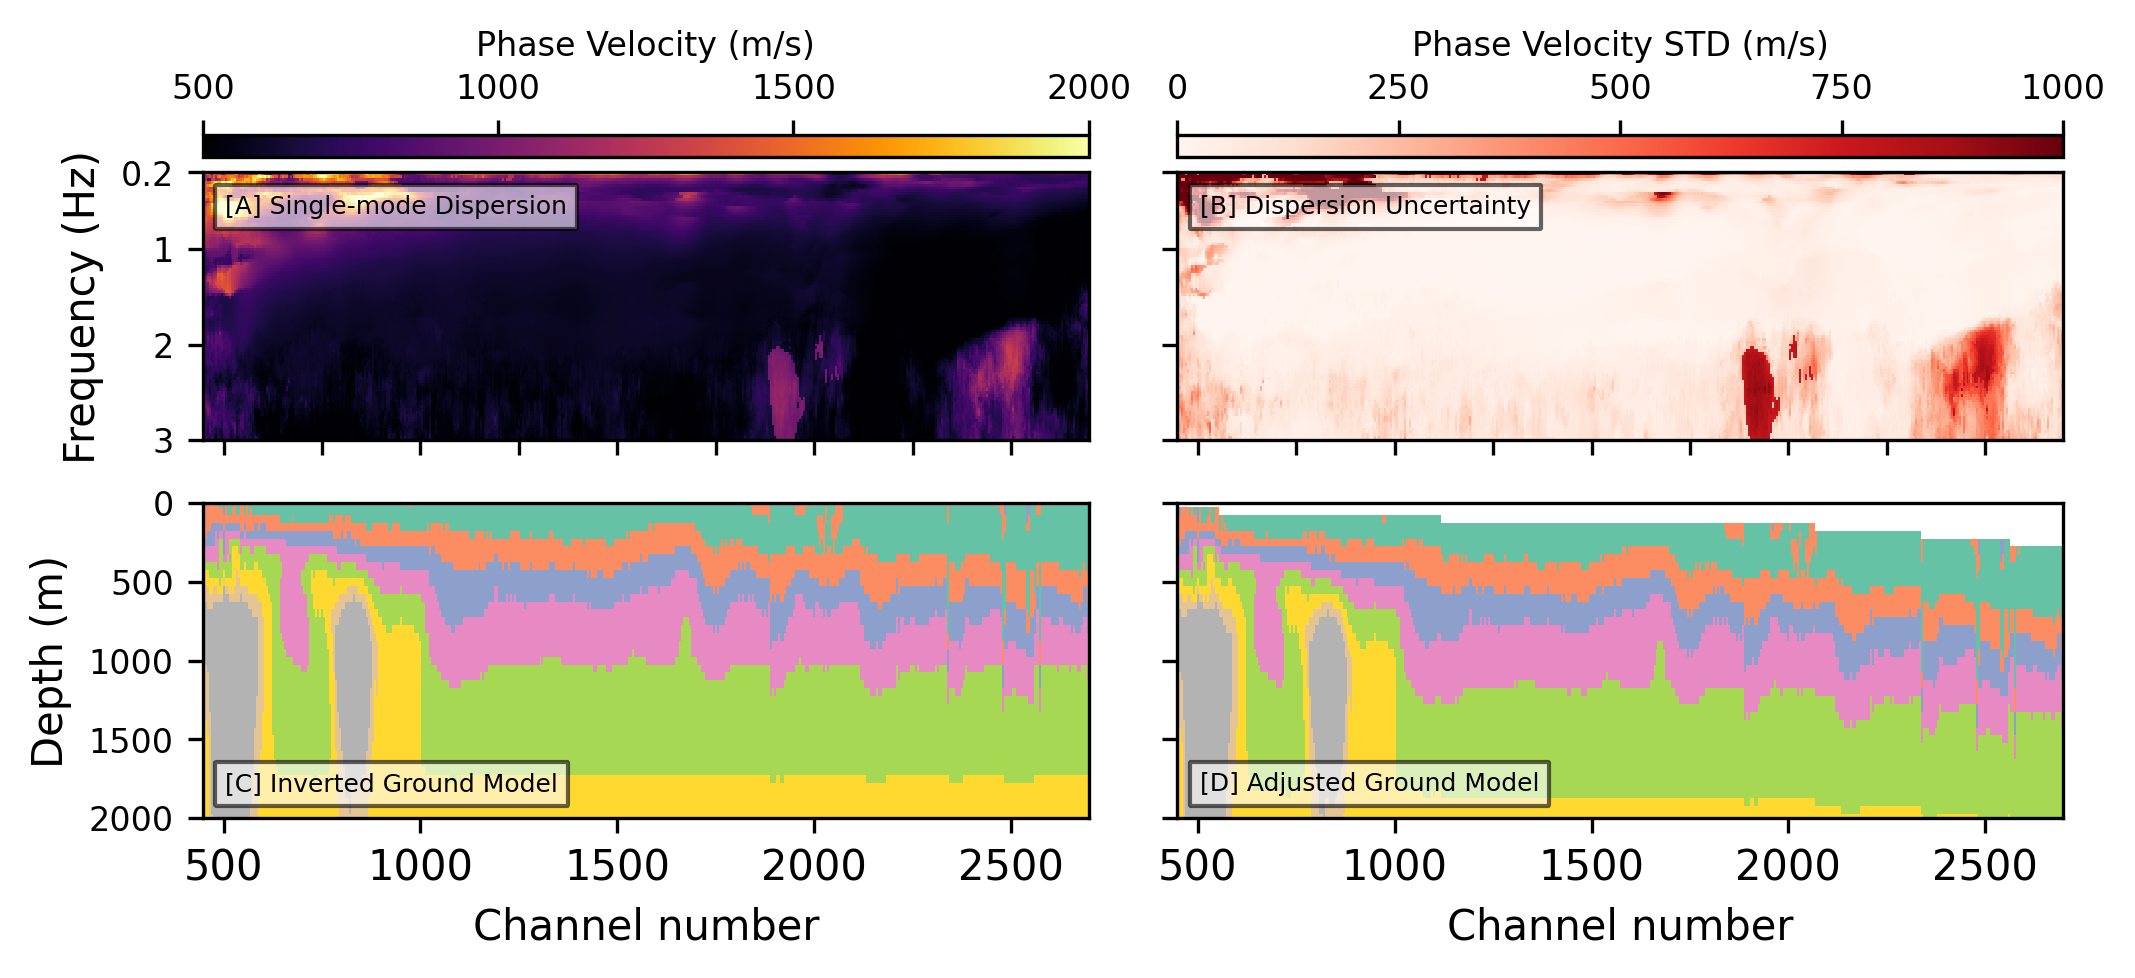

In [120]:
from matplotlib.offsetbox import AnchoredText

fig,axs=plt.subplots(2,2,figsize=(8,3),dpi=300)
axs=axs.flatten()

X,Y=np.meshgrid(chs,frange)
dispersion=axs[0].pcolormesh(X,Y,dispersions[:,:,0].T*1000,cmap='inferno',vmax=2000,vmin=500)
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xticks([500,750,1000,1250,1500,1750,2000,2250,2500])
axs[0].set_xticklabels(['','','','','','','','',''])
axs[0].set_yticks([0.2,1,2,3])
axs[0].set_yticklabels([0.2,1,2,3],fontsize=8)
axs[0].set_ylim(3,0.2)
cbar=fig.colorbar(dispersion,ax=axs[0],orientation='horizontal',location='top',fraction=0.1,aspect=40)
cbar.set_ticks([500,1000,1500,2000])
cbar.set_ticklabels([500,1000,1500,2000])
cbar.set_label('Phase Velocity (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
at = AnchoredText('[A] Single-mode Dispersion',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[0].add_artist(at)

std=axs[1].pcolormesh(X,Y,(dispersions[:,:,1]*dispersions[:,:,0]*1000).T,cmap='Reds',vmax=1000,vmin=0)
# axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xticks([500,750,1000,1250,1500,1750,2000,2250,2500])
axs[1].set_xticklabels(['','','','','','','','',''])
axs[1].set_yticks([0.2,1,2,3])
# axs[1].set_yticklabels([0.2,1,2,3])
axs[1].set_yticklabels(['','','',''])
axs[1].set_ylim(3,0.2)
cbar=fig.colorbar(std,ax=axs[1],orientation='horizontal',location='top',fraction=0.1,aspect=40)
cbar.set_ticks([0,250,500,750,1000])
cbar.set_ticklabels([0,250,500,750,1000])
cbar.set_label('Phase Velocity STD (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
at = AnchoredText('[B] Dispersion Uncertainty',prop=dict(size=6), frameon=True,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[1].add_artist(at)

depths=np.arange(0,4000,50)
X,Y=np.meshgrid(chs,depths)
vs=axs[2].pcolormesh(X,Y,model.T,vmin=500,vmax=2000,cmap='Set2')
axs[2].set_ylabel('Depth (m)')
axs[2].set_ylim(2000,0)
axs[2].set_yticks([0,500,1000,1500,2000])
axs[2].set_yticklabels([0,500,1000,1500,2000],fontsize=8)
# cbar=fig.colorbar(vs,ax=axs[2],orientation='horizontal',location='bottom',fraction=0.1,aspect=40,pad=0.4)
# cbar.set_label('Vs (m/s)',fontsize=8)
# cbar.ax.tick_params(labelsize=8) 
axs[2].set_xlabel('Channel number')
at = AnchoredText('[C] Inverted Ground Model',prop=dict(size=6), frameon=True,loc=3,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[2].add_artist(at)

depths=np.arange(0,4000,50)
X,Y=np.meshgrid(chs,depths)

adjusted_model=np.zeros_like(model)
for i in range(len(model)):
    shifts=int(np.abs(topo[i])//50)+1
    adjusted_model[i,:shifts]=np.nan
    adjusted_model[i,shifts:]=model[i,:model.shape[1]-shifts]
    
vs=axs[3].pcolormesh(X,Y,adjusted_model.T,vmin=500,vmax=2000,cmap='Set2')
axs[3].set_ylim(2000,0)
axs[3].set_yticks([0,500,1000,1500,2000])
axs[3].set_yticklabels(['','','','',''])
# cbar=fig.colorbar(vs,ax=axs[3],orientation='horizontal',location='bottom',fraction=0.1,aspect=40,pad=0.4)
# cbar.set_label('Vs (m/s)',fontsize=8)
# cbar.ax.tick_params(labelsize=8) 
axs[3].set_xlabel('Channel number')
at = AnchoredText('[D] Adjusted Ground Model',prop=dict(size=6), frameon=True,loc=3,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[3].add_artist(at)

plt.subplots_adjust(hspace=0.2,wspace=0.1)

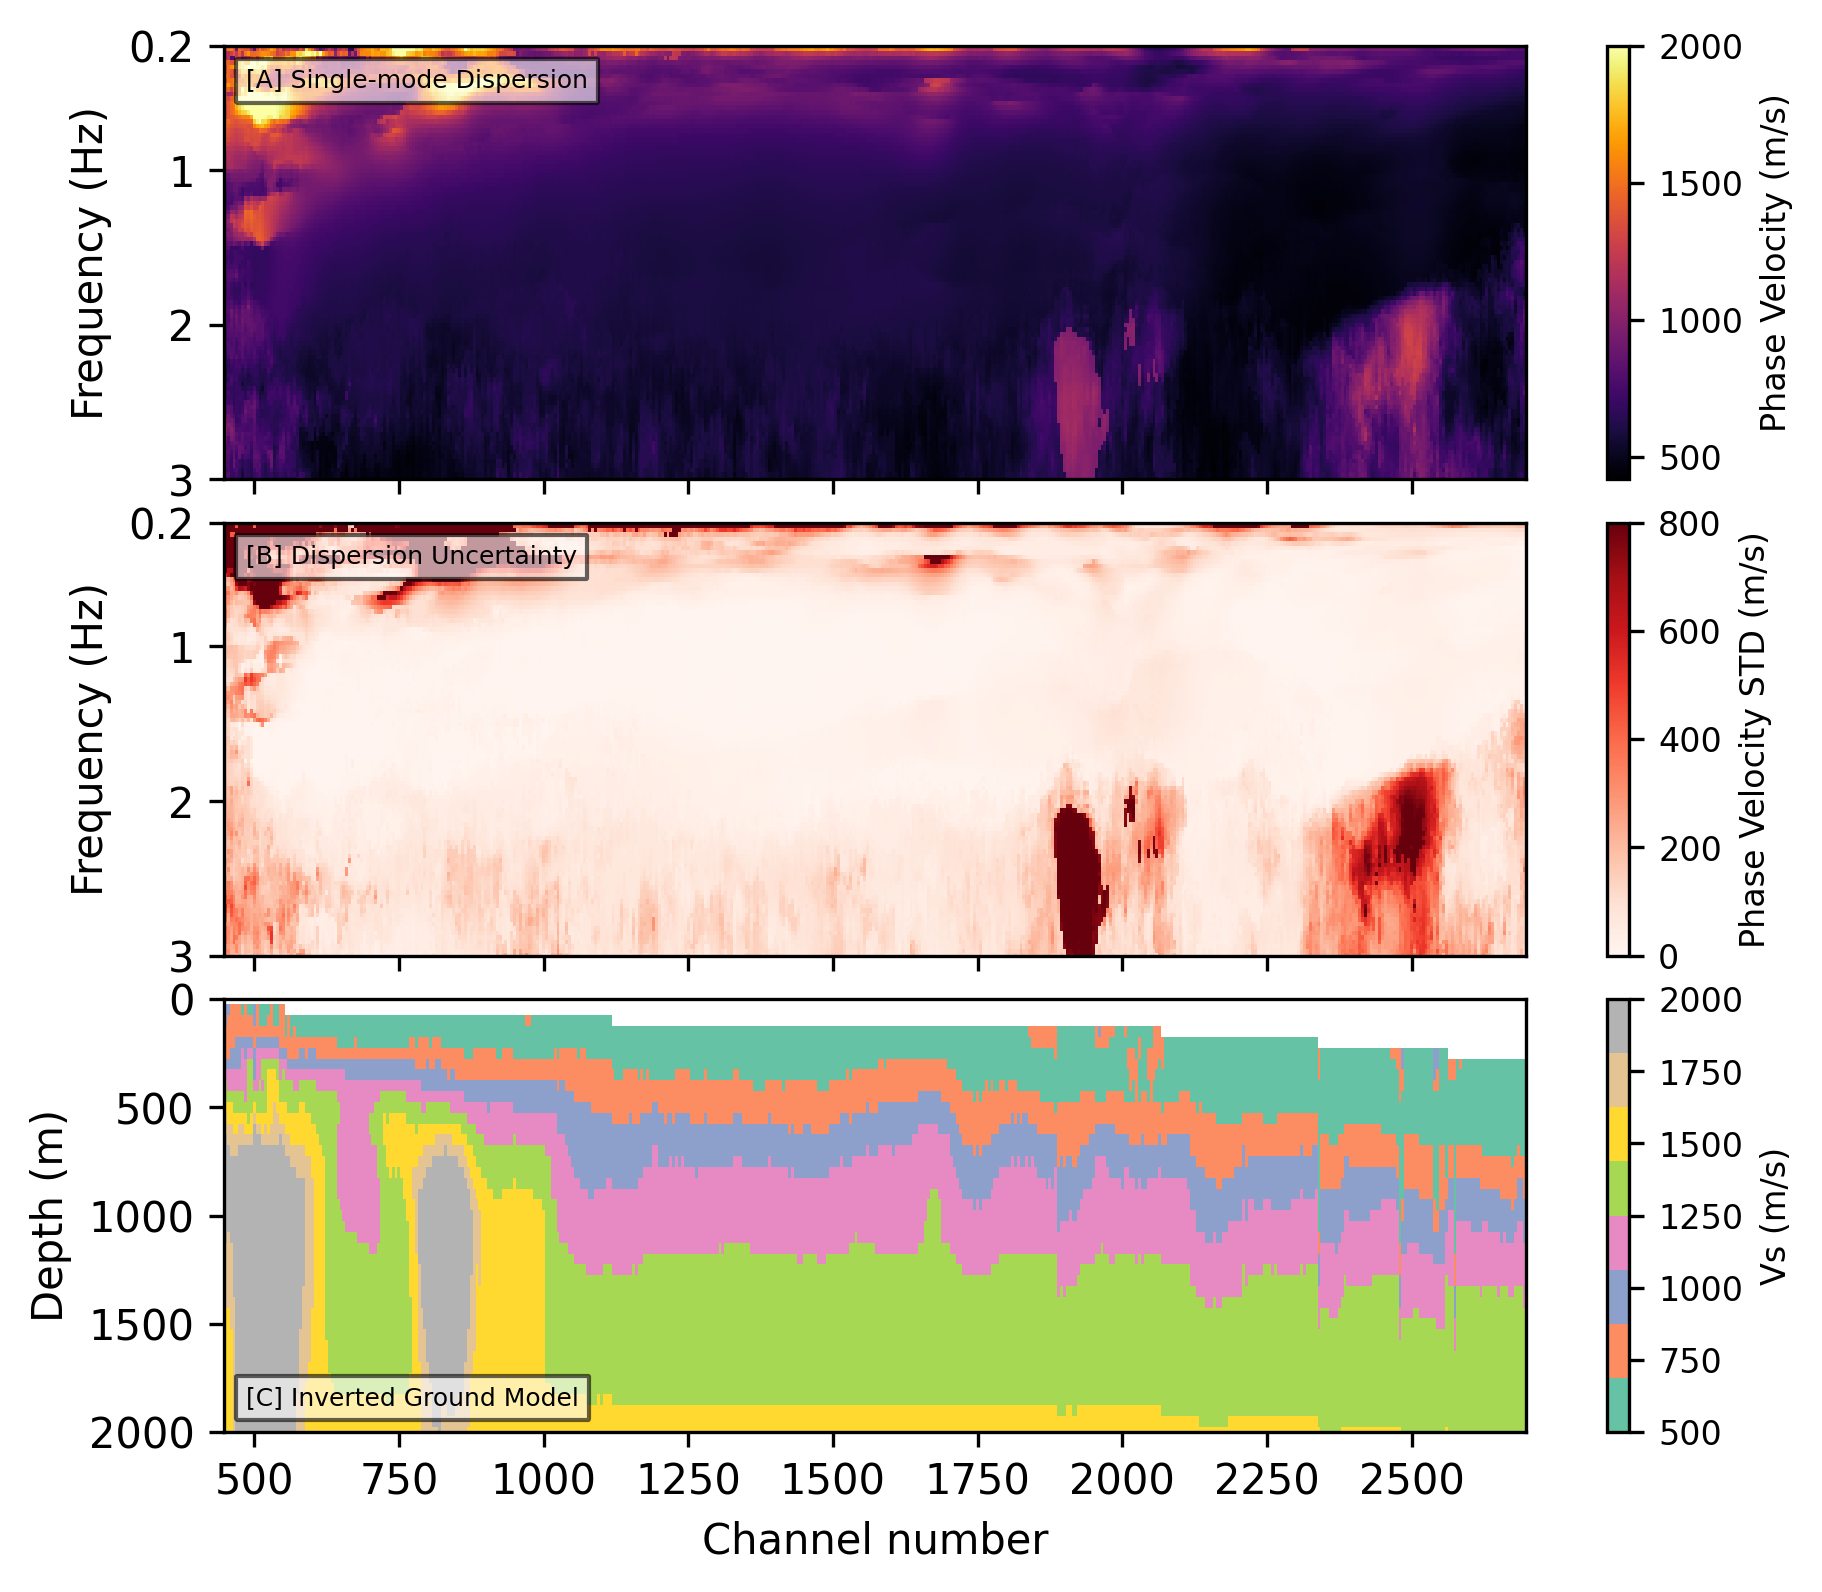

In [130]:
from matplotlib.offsetbox import AnchoredText

fig,axs=plt.subplots(3,1,figsize=(7,6),dpi=300)

X,Y=np.meshgrid(chs,frange)
dispersion=axs[0].pcolormesh(X,Y,dispersions[:,:,0].T*1000,cmap='inferno',vmax=2000)
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xticks([500,750,1000,1250,1500,1750,2000,2250,2500])
axs[0].set_xticklabels(['','','','','','','','',''])
axs[0].set_yticks([0.2,1,2,3])
axs[0].set_yticklabels([0.2,1,2,3])
axs[0].set_ylim(3,0.2)
cbar=fig.colorbar(dispersion,ax=axs[0])
cbar.set_label('Phase Velocity (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
at = AnchoredText('[A] Single-mode Dispersion',prop=dict(size=6), frameon=True,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[0].add_artist(at)

std=axs[1].pcolormesh(X,Y,(dispersions[:,:,1]*dispersions[:,:,0]*1000).T,cmap='Reds',vmax=800,vmin=0)
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xticks([500,750,1000,1250,1500,1750,2000,2250,2500])
axs[1].set_xticklabels(['','','','','','','','',''])
axs[1].set_yticks([0.2,1,2,3])
axs[1].set_yticklabels([0.2,1,2,3])
axs[1].set_ylim(3,0.2)
cbar=fig.colorbar(std,ax=axs[1])
cbar.set_label('Phase Velocity STD (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
at = AnchoredText('[B] Dispersion Uncertainty',prop=dict(size=6), frameon=True,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[1].add_artist(at)

depths=np.arange(0,4000,50)
X,Y=np.meshgrid(chs,depths)
adjusted_model=np.zeros_like(model)
for i in range(len(model)):
    shifts=int(np.abs(topo[i])//50)+1
    adjusted_model[i,:shifts]=np.nan
    adjusted_model[i,shifts:]=model[i,:model.shape[1]-shifts]
    
vs=axs[2].pcolormesh(X,Y,adjusted_model.T,vmin=500,vmax=2000,cmap='Set2')
axs[2].set_ylabel('Depth (m)')
axs[2].set_ylim(2000,0)
cbar=fig.colorbar(vs,ax=axs[2])
cbar.set_label('Vs (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
axs[2].set_xlabel('Channel number')
at = AnchoredText('[C] Inverted Ground Model',prop=dict(size=6), frameon=True,loc=3,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[2].add_artist(at)

plt.subplots_adjust(hspace=0.1)

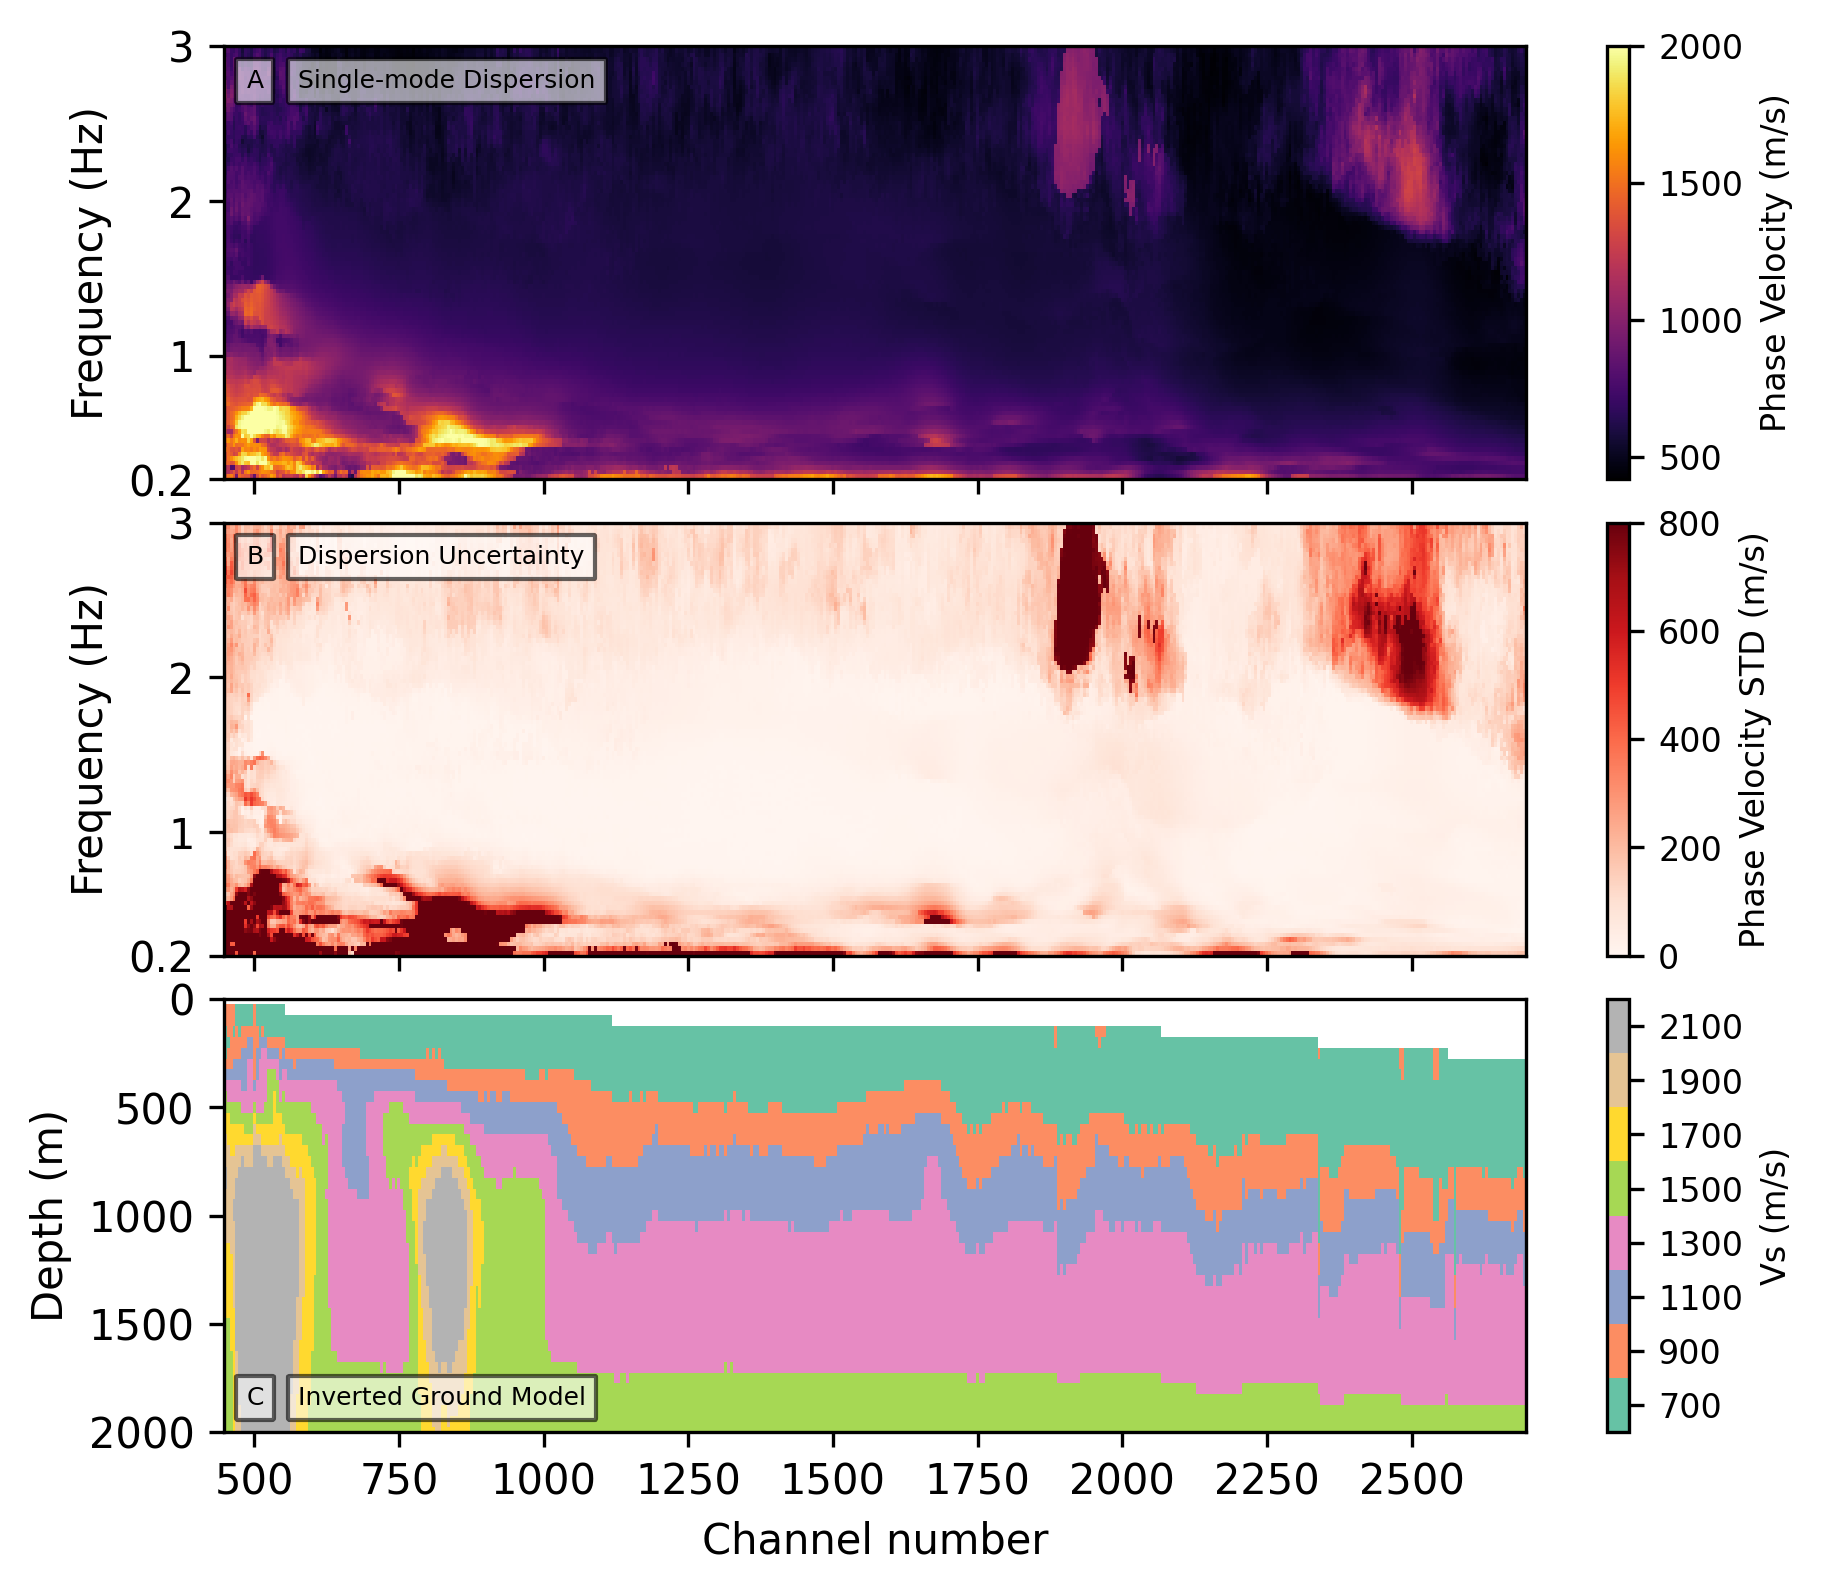

In [9]:
from matplotlib.offsetbox import AnchoredText

fig,axs=plt.subplots(3,1,figsize=(7,6),dpi=300)

X,Y=np.meshgrid(chs,frange)
dispersion=axs[0].pcolormesh(X,Y,dispersions[:,:,0].T*1000,cmap='inferno',vmax=2000)
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_xticks([500,750,1000,1250,1500,1750,2000,2250,2500])
axs[0].set_xticklabels(['','','','','','','','',''])
axs[0].set_yticks([0.2,1,2,3])
axs[0].set_yticklabels([0.2,1,2,3])
axs[0].set_ylim(0.2,3)
cbar=fig.colorbar(dispersion,ax=axs[0])
cbar.set_label('Phase Velocity (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
at = AnchoredText('A',prop=dict(size=6), frameon=True,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[0].add_artist(at)
at = AnchoredText('Single-mode Dispersion',prop=dict(size=6), frameon=True,
                  bbox_to_anchor=(0.04,1),bbox_transform=axs[0].transAxes,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[0].add_artist(at)

std=axs[1].pcolormesh(X,Y,(dispersions[:,:,1]*dispersions[:,:,0]*1000).T,cmap='Reds',vmax=800,vmin=0)
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xticks([500,750,1000,1250,1500,1750,2000,2250,2500])
axs[1].set_xticklabels(['','','','','','','','',''])
axs[1].set_yticks([0.2,1,2,3])
axs[1].set_yticklabels([0.2,1,2,3])
axs[1].set_ylim(0.2,3)
cbar=fig.colorbar(std,ax=axs[1])
cbar.set_label('Phase Velocity STD (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
at = AnchoredText('B',prop=dict(size=6), frameon=True,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[1].add_artist(at)
at = AnchoredText('Dispersion Uncertainty',prop=dict(size=6), frameon=True,
                  bbox_to_anchor=(0.04,1),bbox_transform=axs[1].transAxes,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[1].add_artist(at)

depths=np.arange(0,4000,50)
X,Y=np.meshgrid(chs,depths)
adjusted_model=np.zeros_like(model)
for i in range(len(model)):
    shifts=int(np.abs(topo[i])//50)+1
    adjusted_model[i,:shifts]=np.nan
    adjusted_model[i,shifts:]=model[i,:model.shape[1]-shifts]
    
vs=axs[2].pcolormesh(X,Y,adjusted_model.T,vmin=600,vmax=2200,cmap='Set2')
axs[2].set_ylabel('Depth (m)')
axs[2].set_ylim(2000,0)
cbar=fig.colorbar(vs,ax=axs[2])
cbar.set_label('Vs (m/s)',fontsize=8)
cbar.ax.tick_params(labelsize=8) 
cbar.set_ticks([700,900,1100,1300,1500,1700,1900,2100])
axs[2].set_xlabel('Channel number')
at = AnchoredText('C',prop=dict(size=6), frameon=True,loc=3,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[2].add_artist(at)
at = AnchoredText('Inverted Ground Model',prop=dict(size=6), frameon=True,
                  bbox_to_anchor=(0.04,0),bbox_transform=axs[2].transAxes,loc=3,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.05)
at.patch.set_alpha(0.6)
axs[2].add_artist(at)

plt.subplots_adjust(hspace=0.1)

Text(0, 0.5, 'Phase Velocity (m/s)')

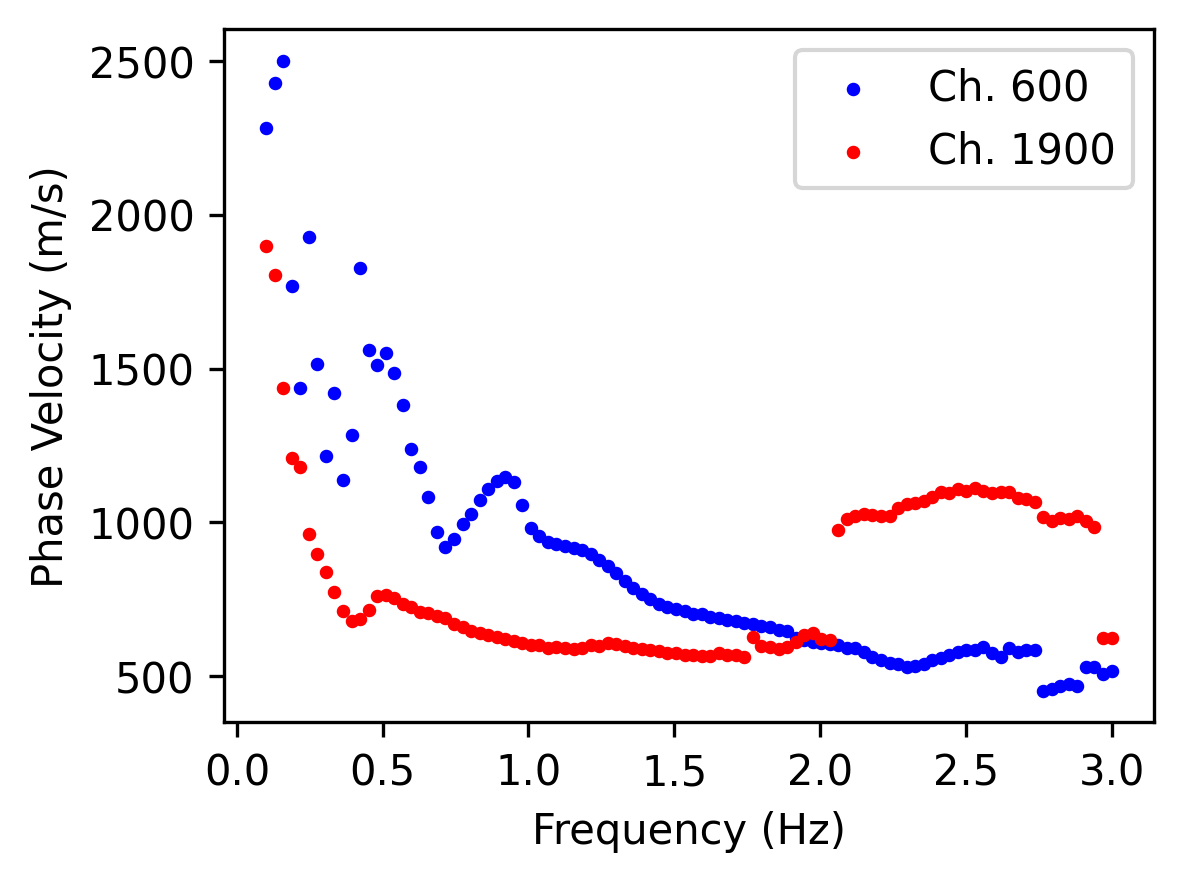

In [185]:
fig,ax=plt.subplots(1,1,figsize=(4,3),dpi=300)

plt.scatter(frange,dispersions[30,:,0].T*1000,c='b',s=5,label='Ch. 600')
plt.scatter(frange,dispersions[290,:,0].T*1000,c='r',s=5,label='Ch. 1900')
# plt.scatter(frange,dispersions[310,:,0].T*1000,c='r',s=5,label='Ch. 2150')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Velocity (m/s)')

In [ ]:
array_ch=1900

finished=np.sort(glob.glob('/scratch/zspica_root/zspica0/yaolinm/Florence/dbf/master/*'))
source_beams=[]
receiver_beams=[]

for beam in finished:
    
    if 'source_'+str(array_ch).zfill(4) in beam:
        source=int(array_ch)
        receiver=int(os.path.basename(beam).split('_')[3])
        
        if 300<=abs(receiver-source)<=800:
            source_beams.append(beam)
            
    if 'receiver_'+str(array_ch).zfill(4) in beam:
        receiver=int(array_ch)
        source=int(os.path.basename(beam).split('_')[1])
        
        if 300<=abs(receiver-source)<=800:
            receiver_beams.append(beam)